Following this:
https://www.tensorflow.org/tutorials/keras/regression

In [46]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow import keras
from keras import layers

from sklearn.metrics import mean_squared_error
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [47]:
tf.__version__

'2.8.0'

In [48]:
df = pd.read_csv('./data/ouput.csv')

In [49]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [50]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

In [51]:
df

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061
...,...,...,...
396557,MAC000150,2014-02-27 22:00:00,0.631
396558,MAC000150,2014-02-27 22:30:00,0.178
396559,MAC000150,2014-02-27 23:00:00,0.108
396560,MAC000150,2014-02-27 23:30:00,0.078


In [52]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

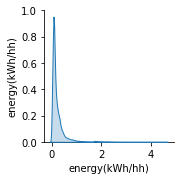

In [53]:
#hmmmmmmmmmm
sns.pairplot(train_dataset[['tstp', 'energy(kWh/hh)']], diag_kind='kde')

In [54]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
energy(kWh/hh),317242.0,0.217255,0.302108,0.0,0.068,0.118,0.25,4.595


In [55]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('energy(kWh/hh)')
test_labels = test_features.pop('energy(kWh/hh)')

In [56]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
energy(kWh/hh),0.217255,0.302108


In [57]:
#Normalize with keras
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [ ]:
normalizer.mean.numpy()

AttributeError: 'Normalization' object has no attribute 'mean'

In [ ]:
#linear regression
energy = np.array(train_features['tstp'])
energy_normalizor = layers.Normalization(input_shape=[1,], axis=None)
energy_normalizor.adapt(energy)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [ ]:
#build the model
energy_model = tf.keras.Sequential([
    energy_normalizor,
    layers.Dense(units=1)
])

energy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
energy_model.predict(energy[:10])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).